In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.linalg import inv, norm

In [ ]:
class KalmanFilter(object):
    def __init__(self, F, Q, H, R, u): 
        """
        Kalman Filter Class for dynamic systems
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.__dict__.update(locals()) 
    
    
    def evolve(self, x0, N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        # init matrices to store states, obs 
        B = np.eye(len(x0)) 
        obs, states = [(x0[0], x0[1])], np.zeros((len(x0), N))  
        states[:, 0] = x0 
         
        for i in range(1, N):   
            # update each x0 and observation 
            x0 = np.dot(F, x0) + np.dot(B, u) + np.random.multivariate_normal(np.zeros(4), self.Q)      
            ob = np.dot(H, x0) + np.random.multivariate_normal(np.zeros(2), self.R)
            # append to matrices 
            obs.append(tuple(ob))
            states[:, i] = x0 
        # return 
        return np.array(obs), states  
        
    def estimate(self, x0, P0, z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # update matrices to store answers 
        n = len(x0) 
        m, N = z.shape 
        state = np.zeros((len(x0), m))  
        state[:, 0] = x0 
        
        for i in range(1, m): 
            # UPDATE STEP 
            x_hat = np.dot(self.F, x0) + self.u 
            P_hat = np.dot(self.F, np.dot(P0, self.F.T)) + self.Q  
            # PREDICT STEP 
            y = z[i] - np.dot(self.H, x_hat) 
            S = np.dot(self.H, np.dot(P_hat, self.H.T)) + self.R 
            K = np.dot(P_hat, np.dot(self.H.T, inv(S))) 
            # store final x0, P0 from iteration 
            x0 = x_hat + np.dot(K, y) 
            P0 = np.dot((np.eye(n) - np.dot(K, self.H)), P_hat)  
            state[:, i] = x0

        return state 
        
    
    def predict(self, x, k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # init array to store answers 
        n = len(x)
        states = np.zeros((n, k))  
        states[:, 0] = x
        
        for i in range(1, k): 
            # update each iteration Fx+u 
            states[:, i] = np.dot(self.F, states[:, i - 1]) + self.u 
            
        return states 

    
    def rewind(self, x, k): 
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # init arrays for states 
        n = len(x) 
        states = np.zeros((n, k)) 
        states[:, 0] = x  
        F_inv = inv(self.F) 
        
        for i in range(1, k): 
            # update at each iteration 
            states[:, i] = np.dot(F_inv, states[:, i - 1] - self.u)  
        
        # return 
        return states[:, :: -1]  

Here we initialize the transition and observation models F and H, along with the control vector u, corresponding to the projectile. Assume that the noise covariances are given by
Q = 0.1 · I4
R = 5000 · I2.
Then we instantiate a KalmanFilter object with these values.

In [ ]:
# inint params for the model 
dt = 0.1 

F = np.array([[1, 0, dt, 0], 
              [0, 1, 0, dt], 
              [0, 0, 1,  0], 
              [0, 0, 0,  1]]) 
 
H = np.eye(4)[: 2] 
Q = dt*np.eye(4) 
R = 5000*np.eye(2) 
u = np.array([0, 0, 0, -dt*9.8]) 

kf = KalmanFilter(F, Q, H, R, u)

Here we use the Kalman Filter to simulate the true and observed trajectory of a projectile with initial state
x0 = [0, 0, 300, 600]

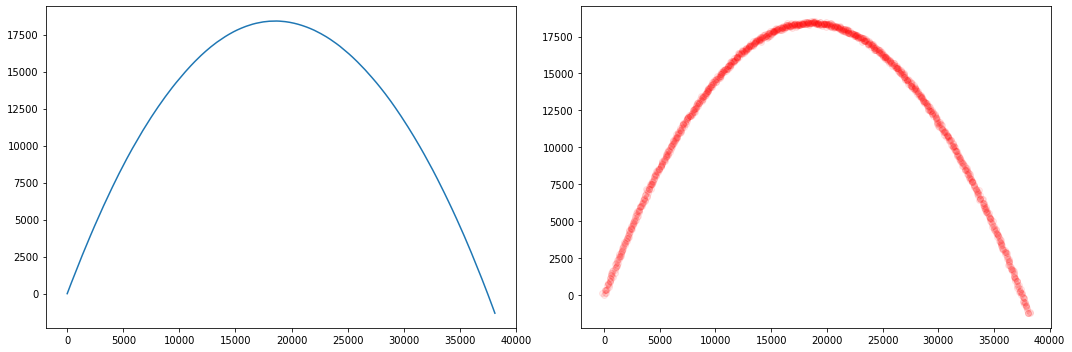

In [ ]:
# init x0 
x0 = np.array([0, 0, 300, 600]) 

# get obs, states 
obs, states = kf.evolve(x0, N = 1250)

sx, sy = zip(*obs) 

x, y = states[0], states[1] 

# plot 
plt.figure(figsize = (15, 5))

plt.subplot(121) 
plt.plot(x, y)

plt.subplot(122) 
plt.plot(sx, sy, "ro", lw = 0.5, alpha = 0.078)
 
plt.tight_layout() 
plt.show() 

We can calculate an initial state estimate xb200 as follows: For the horizontal and vertical positions, we simply use the observed position at time 200. For the velocity, we can compute the average velocity between the observations zk and zk+1 for k = 200, . . . , 208, then average these 9 values
and take this as the initial velocity estimate. Using the initial state estimate, P200 = 10^6Q, and the Kalman Filter, we can compute the next
600 state estimates, i.e. compute xb201, . . . , xb800 and then plot these state estimates as a smooth green curve together with the "radar" observations (as red dots) and the entire true state sequence (as
a blue curve).

In [ ]:
z = obs[200: 800]

x_hat = obs[200]
P_hat = (10**6)*Q

vx, vy = states[2], states[3] 

vxs, vys = [], [] 
for i in range(200, 209):
    vxs.append(0.5*(vx[i] + vx[i + 1]))
    vys.append(0.5*(vy[i] + vy[i + 1])) 
    
vx_mean, vy_mean = np.mean(vxs), np.mean(vys) 

x_initial = np.append(x_hat, [vx_mean, vy_mean]) 

# get estimates from system 
state_est = kf.estimate(x0 = x_initial, P0 = P_hat, z = z, return_norms = False)

In [ ]:
# get plotting 
x_est, y_est = state_est[0], state_est[1]

X_est, Y_est, states_true = np.zeros(1250), -100*np.zeros(1250), -100*np.ones(1250) 

X_est[200: 800] = x_est
Y_est[200: 800] = y_est
states_true[200: 800] = list(sy)[200: 800] 

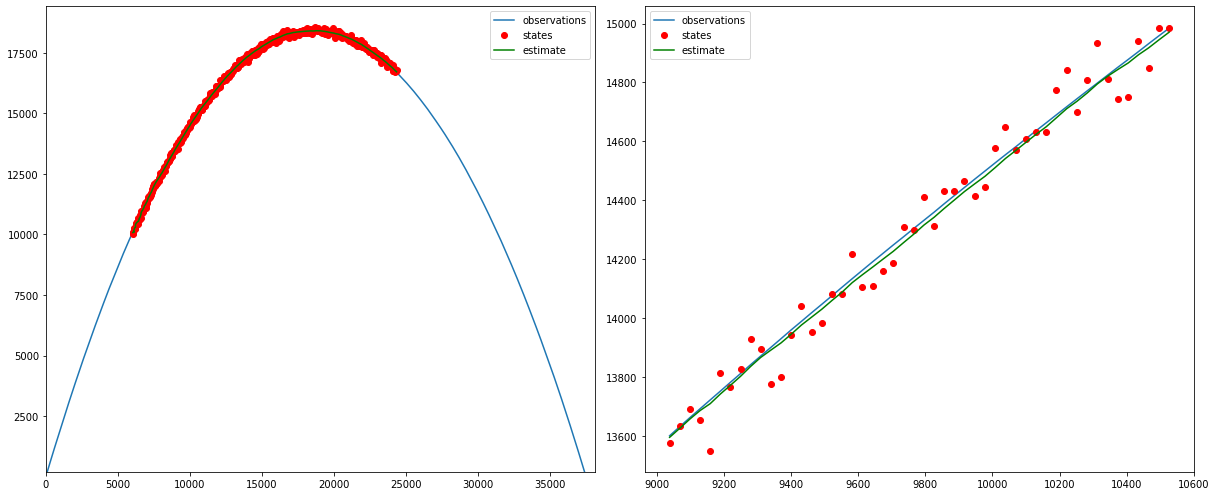

In [ ]:
# plot 
plt.figure(figsize = (17, 7))

plt.subplot(121)
plt.plot(x, y, label = "observations")  
plt.plot(x, states_true, "ro", label = "states") 
plt.plot(x_est, y_est, "g", label = "estimate")  
plt.ylim((200, max(y) + 1000))  
plt.xlim((0, max(x))) 
plt.legend()

plt.subplot(122) 
plt.plot(x[300: 350], y[300: 350], label = "observations")  
plt.plot(x[300: 350], states_true[300: 350], "ro", label = "states") 
plt.plot(x[300: 350], Y_est[300: 350], "g", label = "estimate")
plt.legend()
 

plt.tight_layout()
plt.show() 

Using the final state estimate xb800 that we obtained above, we'll predict the
future states of the projectile until it hits the ground, approximately the next 450 states.

We plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.

In [ ]:
# use kalman filter to predict 
new_est = kf.predict(x = state_est[:, -1], k = 450) 

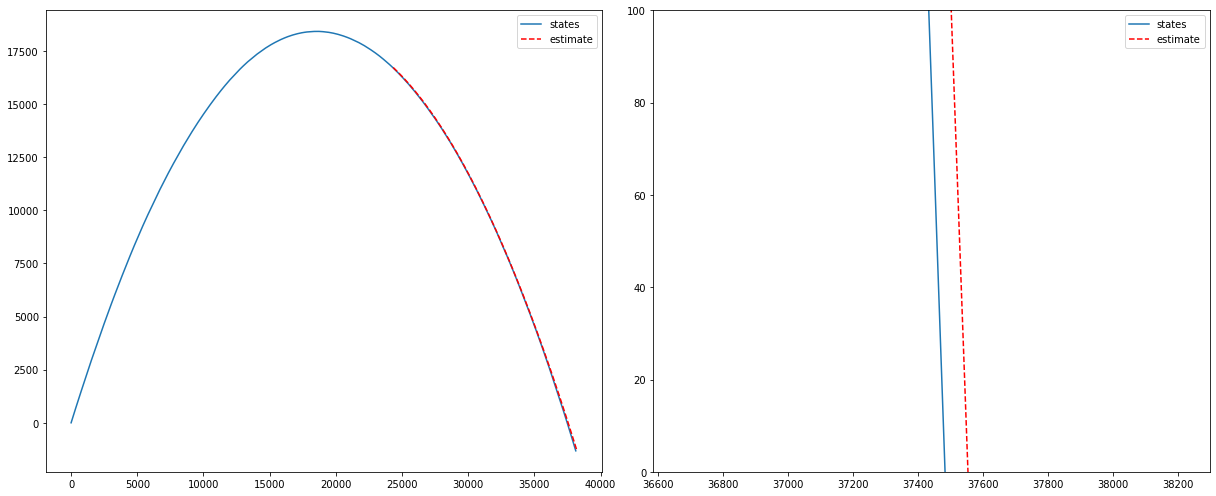

In [ ]:
# plotting 
plt.figure(figsize = (17, 7))

plt.subplot(121) 
plt.plot(x, y, label = "states")  
plt.plot(new_est[0], new_est[1], "r--", label = "estimate") 
plt.legend()

plt.subplot(122) 
plt.plot(x[-50: ], y[-50: ], label = "states")  
plt.plot(new_est[0][-50: ], new_est[1][-50: ], "r--", label = "estimate") 
plt.ylim(0, 100)
plt.legend()

plt.tight_layout()
plt.show() 

Now, using the state estimate xb250, we predict the point of origin of the projectile along with all states leading up to time step 250. We plot these predicted states (in cyan) with the original state sequence. We zoom in to see how accurate the prediction is. 

In [ ]:
# rewind 
est_prev = kf.rewind(x = state_est[:, 50], k = 250)  

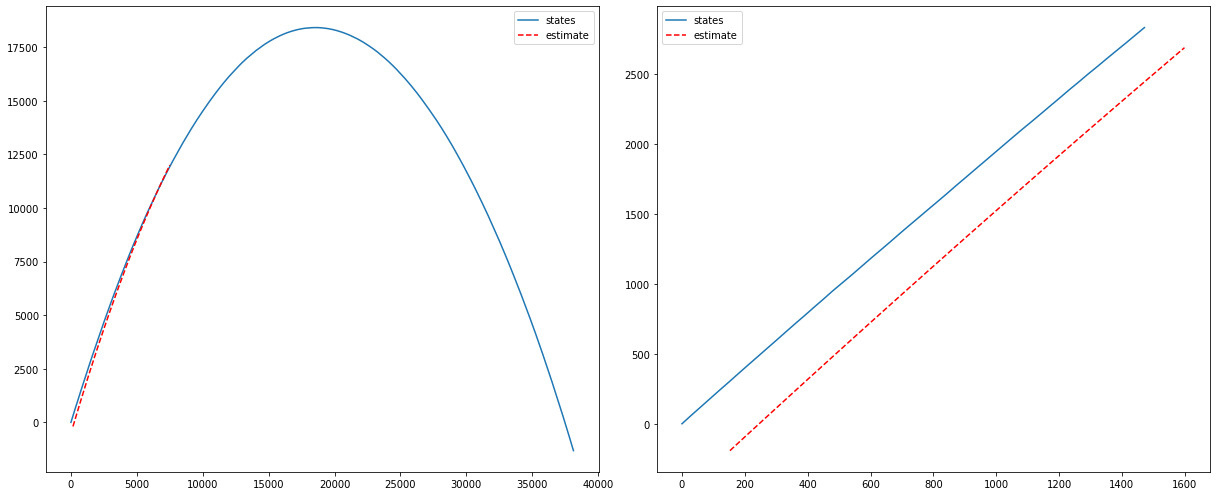

In [ ]:
# plotting 
plt.figure(figsize = (17, 7))

plt.subplot(121) 
plt.plot(x, y, label = "states")  
plt.plot(est_prev[0], est_prev[1], "r--", label = "estimate") 
plt.legend()

plt.subplot(122) 
plt.plot(x[: 50], y[: 50], label = "states")  
plt.plot(est_prev[0][: 50], est_prev[1][: 50], "r--", label = "estimate") 
plt.legend()

plt.tight_layout()
plt.show()